In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline


import os
from pathlib import Path
from PIL import Image
from skimage import io
import numpy as np
from tqdm import tqdm
import torch as t


def process(file_path, has_mask=True):
    file_path = Path(file_path)
    files = sorted(list(Path(file_path).iterdir()))
    datas = []

    for file in tqdm(files):
        item = {}
        imgs = []
        for image in (file/'images').iterdir():
            img = io.imread(image)
            imgs.append(img)
        assert len(imgs)==1
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        img = img[:,:,:3]

        if has_mask:
            mask_files = list((file/'masks').iterdir())
            masks = None
            for ii,mask in enumerate(mask_files):
                mask = io.imread(mask)
                assert (mask[(mask!=0)]==255).all()
                if masks is None:
                    H,W = mask.shape
                    masks = np.zeros((len(mask_files),H,W))
                masks[ii] = mask
            tmp_mask = masks.sum(0)
            assert (tmp_mask[tmp_mask!=0] == 255).all()
            for ii,mask in enumerate(masks):
                masks[ii] = mask/255 * (ii+1)
            mask = masks.sum(0)
            item['mask'] = t.from_numpy(mask)
        item['name'] = str(file).split('/')[-1]
        item['img'] = t.from_numpy(img)
        datas.append(item)
    return datas

# You can skip this if you have alreadly done it.
test = process('./data/stage1_test/',False)
t.save(test, TEST_PATH)
train_data = process('./data/stage1_train/')

100%|██████████| 670/670 [01:48<00:00,  6.20it/s]


In [2]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
#         self.datas = train_data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [3]:
import torch.nn as nn
import torchvision.models as models

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Conv2d(256, 1, kernel_size=1)
        
    def forward(self, x):
        input_spatial_dim = x.size()[2:]
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = nn.functional.upsample_bilinear(input=x, size=input_spatial_dim)
        return x


In [5]:
model = CNN()
optimizer = t.optim.Adam(model.parameters(),lr = 1e-3)

for epoch in range(20):
    for x_train, y_train  in tqdm(dataloader):
        x_train = t.autograd.Variable(x_train)#.cuda())
        y_train = t.autograd.Variable(y_train)#.cuda())
        optimizer.zero_grad()
        o = model(x_train)
        loss = soft_dice_loss(o, y_train)
        loss.backward()
        optimizer.step()


  0%|          | 0/168 [00:00<?, ?it/s]

/afs/inf.ed.ac.uk/user/s17/s1777953/miniconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")

100%|██████████| 168/168 [00:56<00:00,  3.17it/s]


In [6]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,num_workers=2,batch_size=2)

torch.Size([2, 3, 128, 128])
torch.Size([2, 1, 128, 128])


/afs/inf.ed.ac.uk/user/s17/s1777953/miniconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


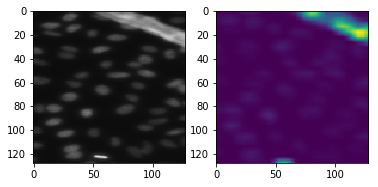

In [7]:
model = model.eval()
for data in testdataloader:
    data = t.autograd.Variable(data, volatile=True)#.cuda())
    o = model(data)
    break

print(data.size())
print(o.size())
tm=o[1][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[1].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])


/afs/inf.ed.ac.uk/user/s17/s1777953/miniconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


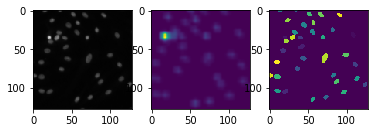

In [8]:
model = model.eval()
for data,mask in dataloader:
    data = t.autograd.Variable(data, volatile=True)#.cuda())
    o = model(data)
    break
print(data.size())
print(o.size())
print(mask.size())
tm=o[1][0].data.cpu().numpy()
plt.subplot(131)
plt.imshow(data[1].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(132)

plt.imshow(tm)
plt.subplot(133)
mask = t.autograd.Variable(mask, volatile=True)
plt.imshow(mask[1][0].data.cpu().numpy())

torch.Size([3, 128, 128])


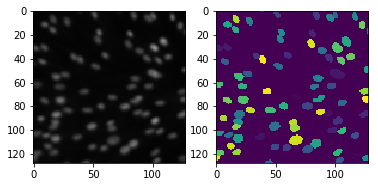

In [9]:
img,mask = dataset[12]
print(img.size())
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())